# Plan for GPU-Optimized Bollinger Bands Strategy

1. **Initial Setup**
   - Replace pandas/numpy imports with cudf/cupy
   - Keep data structure but use GPU DataFrames

2. **Bollinger Bands Calculation**
   - Keep same logic but use cuDF operations
   - All rolling calculations remain vectorized

3. **Signal Generation**
   - Use cuDF boolean masking operations
   - Replace loop with vectorized operations

4. **Position Management** 
   - Create position changes using cumulative operations
   - Use cuDF shift and comparison operations
   - Implement cross-condition logic with vectorized operations

5. **Returns Calculation**
   - Keep vectorized percentage change calculations
   - Use cuDF cumulative product operations

Here's the optimized code:



In [1]:
import cudf
import cupy as cp

def calculate_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['close'].rolling(window=window).mean()
    rolling_std = data['close'].rolling(window=window).std()
    
    data['Middle Band'] = rolling_mean
    data['Upper Band'] = rolling_mean + (rolling_std * num_std)
    data['Lower Band'] = rolling_mean - (rolling_std * num_std)
    
    return data

def backtest_bollinger_strategy(data, initial_capital=100):
    # Calculate Bollinger Bands
    #data = calculate_bollinger_bands(data)
    
    # Generate initial signals
    data['Signal'] = 0
    data.loc[data['close'] < data['Lower Band'], 'Signal'] = 1
    data.loc[data['close'] > data['Upper Band'], 'Signal'] = -1
    
    # Calculate position changes based on middle band crosses
    data['Above_Middle'] = data['close'] > data['Middle Band']

    data['Middle_Cross_Up'] = (data['Above_Middle'] != data['Above_Middle'].shift(1)) & data['Above_Middle']
    
    data['Middle_Cross_Down'] = (data['Above_Middle'] != data['Above_Middle'].shift(1)) & (~data['Above_Middle']) #~ is NOT operator
    
    # Initialize positions
    data['Position'] = data['Signal']
    
    # Update positions based on middle band crosses
    long_exits = data['Middle_Cross_Down'] & (data['Position'].shift(1) == 1)
    short_exits = data['Middle_Cross_Up'] & (data['Position'].shift(1) == -1)
    
    # Apply position updates
    data.loc[long_exits | short_exits, 'Position'] = 0 #when long/short exits trigger, position is reset to zero;
    
    # Forward fill positions
    data['Position'] = data['Position'].fillna(method='ffill')
    data['Position'] = data['Position'].fillna(0)
    
    # Calculate returns
    data['Returns'] = data['close'].pct_change()
    data['Strategy Returns'] = data['Position'].shift(1) * data['Returns']
    
    # Calculate cumulative returns
    data['Cumulative Returns'] = (1 + data['Strategy Returns']).cumprod()
    data['Buy & Hold Returns'] = (1 + data['Returns']).cumprod()
    
    
    return data

In [2]:
df = cudf.read_csv('eurgbp_recent.csv')
df = calculate_bollinger_bands(data=df, window = 60, num_std = 5)
df.dropna(inplace=True)
result = backtest_bollinger_strategy(data=df)
result.tail()

,timestamp,open,high,low,close,volume,Middle Band,Upper Band,Lower Band,Signal,Above_Middle,Middle_Cross_Up,Middle_Cross_Down,Position,Returns,Strategy Returns,Cumulative Returns,Buy & Hold Returns
396376,1737993300000,0.84176,0.84177,0.84155,0.84164,163.77,0.841399,0.842862,0.839936,0,True,False,False,0,-0.000166,-0.0,1.097129,0.970884
396377,1737993360000,0.84162,0.84170,0.84156,0.84166,211.89,0.841413,0.842834,0.839992,0,True,False,False,0,0.000024,0.0,1.097129,0.970907
396378,1737993420000,0.84167,0.84170,0.84152,0.84155,265.92,0.841427,0.842777,0.840076,0,True,False,False,0,-0.000131,-0.0,1.097129,0.970780
396379,1737993480000,0.84155,0.84169,0.84155,0.84161,185.40,0.841444,0.842682,0.840205,0,True,False,False,0,0.000071,0.0,1.097129,0.970849
396380,1737993540000,0.84162,0.84171,0.84158,0.84167,163.71,0.841461,0.842593,0.840329,0,True,False,False,0,0.000071,0.0,1.097129,0.970919


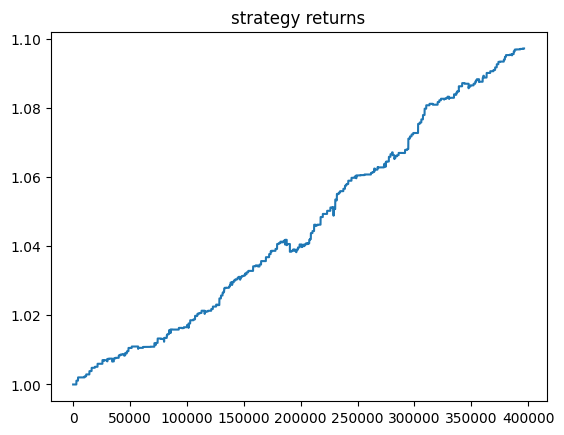

In [5]:
import matplotlib.pyplot as plt
import pandas

plt.plot(df['Cumulative Returns'].to_pandas(), label='Strategy Returns')
plt.title('strategy returns')
plt.show()